In [1]:
import torch
import h5py
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms
from matplotlib import cm
from google.colab import drive
import matplotlib.pyplot as plt
import os
import sys

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Checkpoint File Handling for Model Loading

This section handles the loading of a model checkpoint from Google Drive and checks the type of checkpoint (whether it's a dictionary containing weights or a full model). Based on the type, it processes the checkpoint accordingly.

In [3]:
# Path to the checkpoint file on Google Drive
checkpoint_path = '/content/drive/MyDrive/CrowdCounting/Models/checkpoint_regression_one_dense.pth'

# Load checkpoint
checkpoint = torch.load(checkpoint_path)

# Check the type of the checkpoint
if isinstance(checkpoint, dict):
    # If checkpoint contains weights (dict)
    print("Checkpoint contains weights (dict).")
    print("Keys:", checkpoint.keys())  # Display the keys in the dictionary (wrong dictionary)
elif isinstance(checkpoint, torch.nn.Module):
    # If checkpoint contains model architecture and weights
    print("Checkpoint contains model architecture and weights (torch.nn.Module).")
else:
    # If the checkpoint type is unknown
    print("Unknown checkpoint format.")

<ipython-input-3-17f29eff5efb>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint contains weights (dict).
Keys: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_loss', 'val_loss'])


## Loading Weights and Model Initialization

This section loads the weights from a `.npz` file, checks the available keys, and then appends the model path to the system path. Additionally, it downloads the pre-trained VGG16 model to initialize the model for further use.

In [4]:
# Path to the weights file
weights_path = '/content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz'

# Load the .npz file
weights = np.load(weights_path)

# Check the keys in the file
print(weights.files)  # Print the keys in the .npz file

['frontend.0.weight', 'frontend.0.bias', 'frontend.2.weight', 'frontend.2.bias', 'frontend.5.weight', 'frontend.5.bias', 'frontend.7.weight', 'frontend.7.bias', 'frontend.10.weight', 'frontend.10.bias', 'frontend.12.weight', 'frontend.12.bias', 'frontend.14.weight', 'frontend.14.bias', 'frontend.17.weight', 'frontend.17.bias', 'frontend.19.weight', 'frontend.19.bias', 'frontend.21.weight', 'frontend.21.bias', 'backend.0.weight', 'backend.0.bias', 'backend.2.weight', 'backend.2.bias', 'backend.4.weight', 'backend.4.bias', 'backend.6.weight', 'backend.6.bias', 'backend.8.weight', 'backend.8.bias', 'backend.10.weight', 'backend.10.bias', 'output_layer.weight', 'output_layer.bias']


In [5]:
sys.path.append('/content/drive/MyDrive/CrowdCounting/CSRNet-pytorch')

In [6]:
from model import CSRNet  # Import the CSRNet model from model.py

# Select device (GPU if available, CPU if not)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = CSRNet(load_weights=False).to(device)

## Loading the Model and Checkpoint

This section describes the process of loading the model and its checkpoint, updating the keys to match the model's expected structure, and setting the model to evaluation mode for prediction.

In [7]:
# Initialize the model (without loading weights)
model = CSRNet(load_weights=False).to(device)

# Path to the checkpoint file
checkpoint_path = '/content/drive/MyDrive/CrowdCounting/Models/checkpoint_regression_one_dense.pth'

# Load the checkpoint (checkpoint is in dict format)
checkpoint = torch.load(checkpoint_path)

# Extract model weights from checkpoint
checkpoint_dict = checkpoint['model_state_dict']

# Update keys to match the model's expected keys
new_checkpoint_dict = {}
for key, value in checkpoint_dict.items():
    new_key = key.replace('feature_extractor.csrnet.', '')  # Remove the unexpected prefix
    new_checkpoint_dict[new_key] = value

# Load the updated state dict into the model
model.load_state_dict(new_checkpoint_dict, strict=False)  # strict=False to ignore missing keys

<ipython-input-7-416c92bc134c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['dense.weight', 'dense.bias'])

In [8]:
# Switch model to evaluation mode
model.eval()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

## Prediction

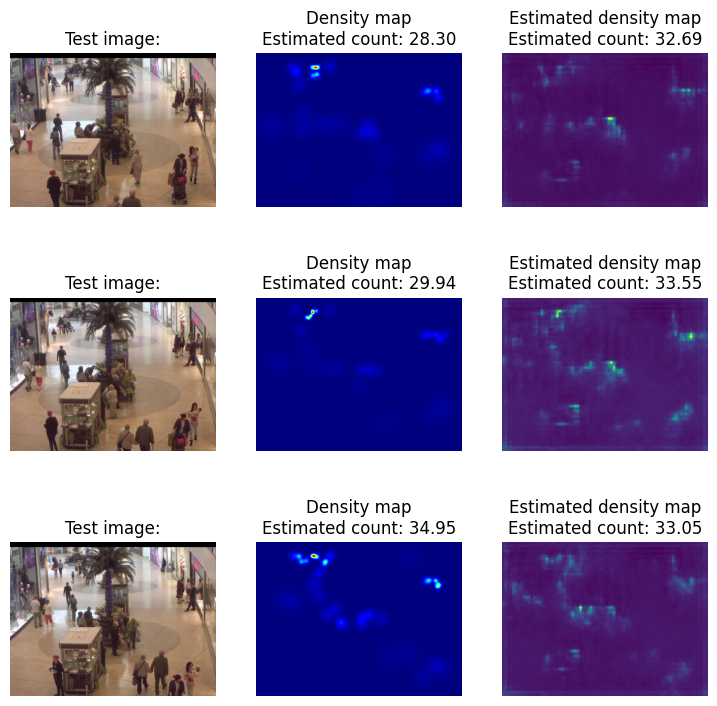

In [9]:
# Ensure the device is defined (GPU if available, CPU otherwise)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the dataset path is correctly defined
path_dataset = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/'

# Filter only .jpg image files from the 'frames' directory
test_img_names = sorted([f for f in os.listdir(path_dataset) if f.endswith('.jpg')])
test_den_names = sorted([f for f in os.listdir(path_dataset.replace('frames', 'density_maps')) if f.endswith('.h5')])  # Filter only .h5 files from 'density_maps'

# Transform images into tensors and normalize pixel values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

to_print = 3
plt.figure(figsize=(9, 3 * to_print))

# Visualize the images and density maps
for i, (img_name, den_map_name) in enumerate(zip(test_img_names, test_den_names)):
    if i == to_print: break

    # Read the original image from the 'frames' directory
    img = transform(Image.open(path_dataset + img_name).convert('RGB')).to(device)
    output = model(img.unsqueeze(0))  # Prediction

    # Move the output back to CPU for visualization
    estimated_den_map = output.squeeze().detach().cpu().numpy()

    # Read the original image using OpenCV
    img = cv2.imread(path_dataset + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Read the density map from the .h5 file
    den_map_file = h5py.File(path_dataset.replace('frames', 'density_maps') + den_map_name, 'r')
    den_map = np.asarray(den_map_file['density'])  # Extract data from the 'density' key

    # Display the test image
    plt.subplot(to_print, 3, i * 3 + 1)
    plt.axis("off")
    plt.title("Test image:")
    plt.imshow(img)

    # Display the ground truth density map (GT density map)
    plt.subplot(to_print, 3, i * 3 + 2)
    plt.axis("off")
    plt.title(f"Density map\nEstimated count: {np.sum(den_map):.2f}")  # Use the sum of the density map as GT count
    plt.imshow(den_map, cmap=cm.jet)

    # Display the estimated density map
    estimated_count = np.sum(estimated_den_map)
    plt.subplot(to_print, 3, i * 3 + 3)
    plt.axis("off")
    plt.title(f"Estimated density map\nEstimated count: {estimated_count:.2f}")
    plt.imshow(estimated_den_map)

In [10]:
# Lưu toàn bộ mô hình (bao gồm cả trọng số và cấu trúc mô hình)
torch.save(model, '/content/drive/MyDrive/CrowdCounting/Models/csrnet_full_model.pth')